 In this project we received data from 3 brain regions of 170 subjects. The three regions are taken from the visual network(VIS), the attention network(ATN), and the default network(PCC).

 The data was collected while the subjects watched 14 short films, including 'rest' time between films.

 For each subject we received 6 different data files: 3 files containing data from the brain while watching the film and 3 files of resting data.

 The purpose of the project is to identify the specific movie watched by the subject from his brain activity. For that we falttened each matrix into a vector and attached a specific label to it (which represent the movie ).
For classification, we used the following linear classifiers: KNN, SVM, LDA, QDA and Naive Bayes.

Our ambition was to use leave-one-out-cross-validation for optimal identification, increasing accuracy and reducing error, but we encountered processing difficulties that prevented us from using it.
These difficulties also prevented us from implementing other models, such as XGBoost. In order to deal with this difficulty, we used k-fold-cross-validation.

The project was divided into 2 main parts:

Part 1-

In this part our goal was to classify the films being watched, based on the first and last 5 seconds of each film (the beginning of film sampling is from the last 50 seconds of the film, meaning that in the first 5 seconds  there was already an increase in the brain activity of each subject).

Part 2-

In this part, the goal was to classify which film the subject watched according to the resting data(first and last 5 seconds). We would like to mention that we expected the lowest results for the last 5 seconds, mainly because of a decrease in brain activity (end of rest).

In addition, we would like to point out that in our opinion, the size of the data - about 170 samples per film, is not large enough to optimally train the model. We think that with bigger database we would have achieved better classification.

# Part 1 - Classification of 14 movies according to the last and first 5 seconds of each movie

# Imports

In [ ]:
!pip install xgboost scikit-learn

In [ ]:
!pip install nilearn brainvoyagertools mplcursors ipympl --quiet

In [ ]:
import warnings
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import nibabel as nib
from scipy.io import loadmat
from nilearn.maskers import NiftiSpheresMasker
from brainvoyagertools.voi import VOIsDefinition as voi_reader
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib widget
from nilearn.image import load_img, coord_transform
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load + Data Preprocessing

In [ ]:
atn_movie = loadmat('/content/drive/MyDrive/FMRI_FINAL/atn_roi_movie.mat')
pcc_movie = loadmat('/content/drive/MyDrive/FMRI_FINAL/pcc_roi_movie.mat')
vis_movie = loadmat('/content/drive/MyDrive/FMRI_FINAL/vis_roi_movie.mat')

In [ ]:
atn_movie = atn_movie['atn_roi_movie']
atn_movie.shape

(170, 14, 50, 361)

In [ ]:
pcc_movie = pcc_movie['pcc_roi_movie']
pcc_movie.shape

(170, 14, 50, 192)

In [ ]:
vis_movie = vis_movie['vis_roi_movie']
vis_movie.shape

(170, 14, 50, 101)

In [ ]:
def transform_matrix(file, index_first):
    # Reshape to (170*14, Z, N)
    reshaped_file = file.reshape(170 * 14, file.shape[2], file.shape[3])

    if (index_first):  #if True the function return first 5 sec
      five_seconds_metrix = reshaped_file[:, :5, :]
    else: #  #if False the function return last 5 sec
      five_seconds_metrix = reshaped_file[:, -5:, :]

    return five_seconds_metrix

In [ ]:
first_5sec_atn_movie=transform_matrix(atn_movie, True)
last_5sec_atn_movie=transform_matrix(atn_movie, False)

first_5sec_pcc_movie=transform_matrix(pcc_movie, True)
last_5sec_pcc_movie=transform_matrix(pcc_movie, False)

first_5sec_vis_movie=transform_matrix(vis_movie, True)
last_5sec_vis_movie=transform_matrix(vis_movie, False)

In [ ]:
print(f"the shape of first_5sec_atn_movie: {first_5sec_atn_movie.shape}")
print(f"the shape of first_5sec_pcc_movie: {first_5sec_pcc_movie.shape}")
print(f"the shape of first_5sec_vis_movie: {first_5sec_vis_movie.shape}")

print(f"the shape of last_5sec_atn_movie: {last_5sec_atn_movie.shape}")
print(f"the shape of last_5sec_pcc_movie: {last_5sec_pcc_movie.shape}")
print(f"the shape of last_5sec_vis_movie: {last_5sec_vis_movie.shape}")

the shape of first_5sec_atn_movie: (2380, 5, 361)
the shape of first_5sec_pcc_movie: (2380, 5, 192)
the shape of first_5sec_vis_movie: (2380, 5, 101)
the shape of last_5sec_atn_movie: (2380, 5, 361)
the shape of last_5sec_pcc_movie: (2380, 5, 192)
the shape of last_5sec_vis_movie: (2380, 5, 101)


In [ ]:
labels = []
for i in range(170):
    for j in range(14):
        labels.append(j)

labels = np.array(labels)
print(labels.shape)

(2380,)


In [ ]:
labels_atn = labels.copy()
labels_pcc = labels.copy()
labels_vis = labels.copy()

In [ ]:
first_5sec_atn_movie_flat = np.reshape(first_5sec_atn_movie, (2380, -1))
first_5sec_pcc_movie_flat = np.reshape(first_5sec_pcc_movie, (2380, -1))
first_5sec_vis_movie_flat = np.reshape(first_5sec_vis_movie, (2380, -1))

last_5sec_atn_movie_flat = np.reshape(last_5sec_atn_movie, (2380, -1))
last_5sec_pcc_movie_flat = np.reshape(last_5sec_pcc_movie, (2380, -1))
last_5sec_vis_movie_flat = np.reshape(last_5sec_vis_movie, (2380, -1))

In [ ]:
X_train_atn_first_movie, X_test_atn_first_movie, y_train_atn_first_movie, y_test_atn_first_movie = train_test_split(first_5sec_atn_movie_flat, labels_atn, test_size=0.2, random_state=42)
X_train_atn_last_movie, X_test_atn_last_movie, y_train_atn_last_movie, y_test_atn_last_movie = train_test_split(last_5sec_atn_movie_flat, labels_atn, test_size=0.2, random_state=42)

In [ ]:
X_train_pcc_first_movie, X_test_pcc_first_movie, y_train_pcc_first_movie, y_test_pcc_first_movie = train_test_split(first_5sec_pcc_movie_flat, labels_pcc, test_size=0.2, random_state=42)
X_train_pcc_last_movie, X_test_pcc_last_movie, y_train_pcc_last_movie, y_test_pcc_last_movie = train_test_split(last_5sec_pcc_movie_flat, labels_pcc, test_size=0.2, random_state=42)

In [ ]:
X_train_vis_first_movie, X_test_vis_first_movie, y_train_vis_first_movie, y_test_vis_first_movie = train_test_split(first_5sec_vis_movie_flat, labels_pcc, test_size=0.2, random_state=42)
X_train_vis_last_movie, X_test_vis_last_movie, y_train_vis_last_movie, y_test_vis_last_movie = train_test_split(last_5sec_vis_movie_flat, labels_vis, test_size=0.2, random_state=42)

# Model_function

In [ ]:
def k_fold_cross_validation(X_train, y_train, k=3):
    classifiers = {
        'KNN': (KNeighborsClassifier(), {'clf__n_neighbors': [7, 8, 9]}),
        'SVM': (SVC(), {'clf__C': [5, 10, 15], 'clf__kernel': ['linear', 'rbf'], 'clf__gamma': [0.0005, 0.001, 0.005]}),
        'QDA': (QuadraticDiscriminantAnalysis(), {}),
        'LDA': (LinearDiscriminantAnalysis(), {'clf__solver': ['svd']}),
        'Naive Bayes': (GaussianNB(), {})
    }

    accuracies = {}   # A dictionary to store the mean accuracy for each classifier
    best_params = {}
    kf = KFold(n_splits=k)  # Initializes a KFold object with k splits for cross-validation

    best_accuracy = 0
    best_model = None
    best_model_name = ""

    for clf_name, (clf, params) in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])

        if params:
            grid_search = GridSearchCV(pipeline, param_grid=params, cv=kf)
            grid_search.fit(X_train, y_train)
            best_clf = grid_search.best_estimator_
            scores = cross_val_score(best_clf, X_train, y_train, cv=kf)
            best_params[clf_name] = grid_search.best_params_
        else:
            scores = cross_val_score(pipeline, X_train, y_train, cv=kf)
            best_clf = pipeline.fit(X_train, y_train)

        accuracies[clf_name] = scores.mean()

        if scores.mean() > best_accuracy:
            best_accuracy = scores.mean()
            best_model = best_clf
            best_model_name = clf_name

    return best_model, best_model_name, accuracies, best_params

In [ ]:
def plot_accuracy_vs_model(accuracies_first, accuracies_last, title):
    classifiers = list(accuracies_first.keys())
    first_scores = [accuracies_first[clf] for clf in classifiers]
    last_scores = [accuracies_last[clf] for clf in classifiers]

    x = np.arange(len(classifiers))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, first_scores, width, label='First 5 Seconds', color='skyblue')
    rects2 = ax.bar(x + width/2, last_scores, width, label='Last 5 Seconds', color='salmon')

    ax.set_xlabel('Classifiers')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(classifiers)
    ax.legend()
    ax.set_ylim([0, 1])  # Setting y-axis limit to ensure visibility of differences

    fig.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for Best Model: {model_name}')
    plt.show()

def print_test_accuracy(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy of the best model ({model_name}): {test_accuracy * 100:.2f}%")


#Modle_ATN

In [ ]:
# Training models for ATN
best_model_first_movie_ATN, best_model_name_first_movie_ATN, accuracies_first_movie_ATN, best_params_first_movie_ATN =  k_fold_cross_validation(X_train_atn_first_movie,
                                                                                                                                y_train_atn_first_movie, k=3)
best_model_last_movie_ATN, best_model_name_last_movie_ATN, accuracies_last_movie_ATN, best_params_last_movie_ATN = k_fold_cross_validation(X_train_atn_last_movie, y_train_atn_last_movie,k=3)


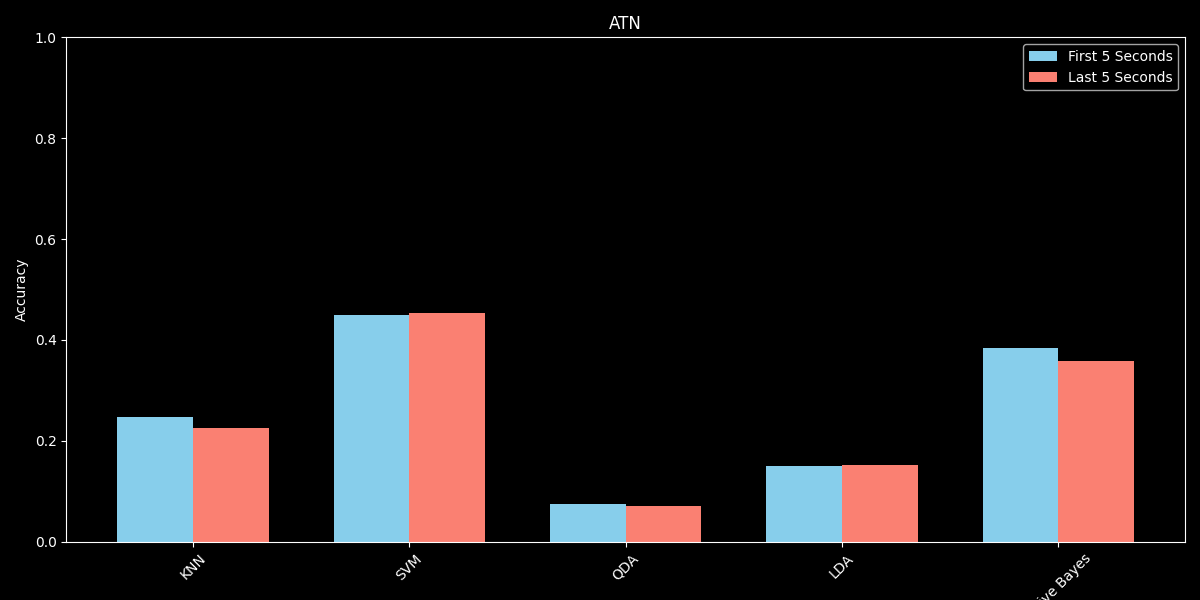

In [ ]:
# Plotting results for ATN
plot_accuracy_vs_model(accuracies_first_movie_ATN, accuracies_last_movie_ATN, 'ATN')

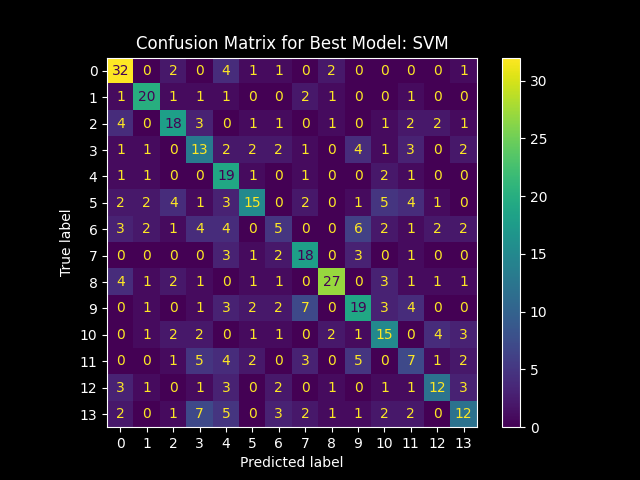

Test Accuracy of the best model (SVM): 48.74%


In [ ]:
# plot_confusion_matrix for first 5-sec
plot_confusion_matrix(best_model_first_movie_ATN, X_test_atn_first_movie, y_test_atn_first_movie, best_model_name_first_movie_ATN)

# print_test_accuracy for first 5-sec
print_test_accuracy(best_model_first_movie_ATN, X_test_atn_first_movie, y_test_atn_first_movie, best_model_name_first_movie_ATN)

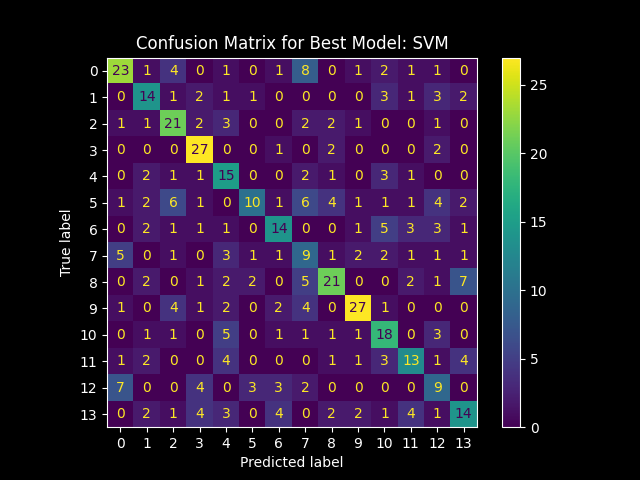

Test Accuracy of the best model (SVM): 49.37%


In [ ]:
# plot_confusion_matrix for last 5-sec
plot_confusion_matrix(best_model_last_movie_ATN, X_test_atn_last_movie, y_test_atn_last_movie, best_model_name_last_movie_ATN)

# print_test_accuracy for last 5-sec
print_test_accuracy(best_model_last_movie_ATN, X_test_atn_last_movie, y_test_atn_last_movie, best_model_name_last_movie_ATN)

Conclusions:


The ATN is crucial for maintaining focus, tracking the storyline, and processing visual and auditory information, which are essential for understanding and engaging with the movie. Its activity directly reflects viewers' focus and cognitive engagement, producing distinct and recognizable brain activity patterns as they pay attention to different aspects of the film.

Given the ATN’s involvement in these cognitive processes, it provides the most useful and distinguishable patterns for classifying which movie a subject watched.

This is why we observed the highest accuracy for the ATN using the SVM linear classification, which is effective at finding the optimal hyperplane to separate data points in high-dimensional space. (As we mentioned before, accuracies are not high because the database is too small, in our opinion).

#Modle_PCC

In [ ]:
# Training models for PCC
best_model_first_movie_PCC, best_model_name_first_movie_PCC, accuracies_first_movie_PCC, best_params_first_movie_PCC =  k_fold_cross_validation(X_train_pcc_first_movie,
                                                                                                                                y_train_pcc_first_movie, k=3)
best_model_last_movie_PCC, best_model_name_last_movie_PCC, accuracies_last_movie_PCC, best_params_last_movie_PCC = k_fold_cross_validation(X_train_pcc_last_movie, y_train_pcc_last_movie,k=3)


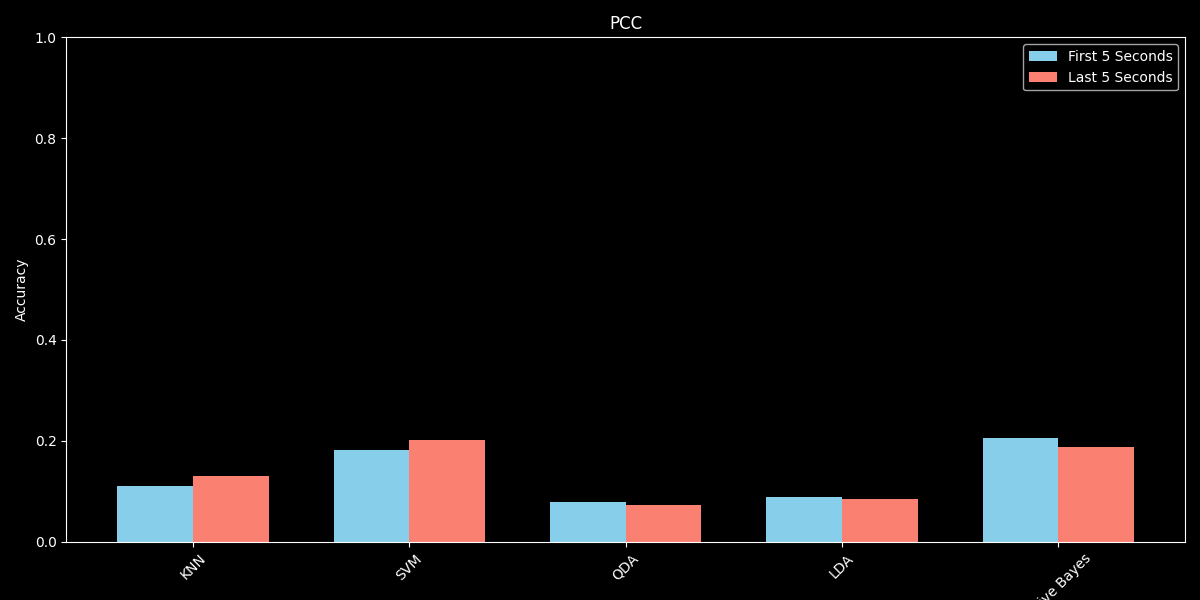

In [ ]:
# Plotting results for PCC
plot_accuracy_vs_model(accuracies_first_movie_PCC, accuracies_last_movie_PCC, 'PCC')

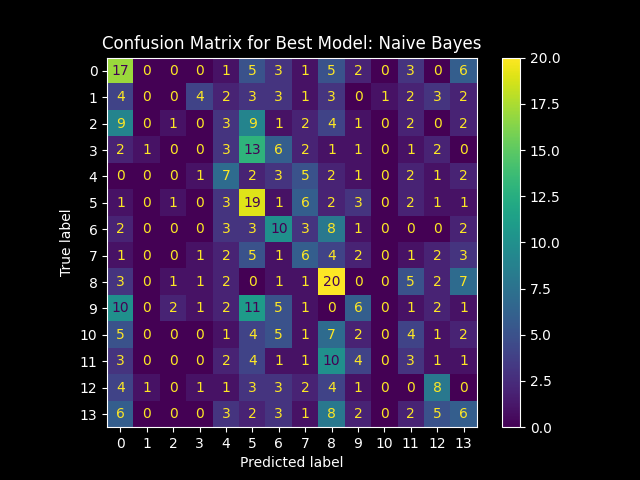

Test Accuracy of the best model (Naive Bayes): 21.64%


In [ ]:
# plot_confusion_matrix for first 5-sec
plot_confusion_matrix(best_model_first_movie_PCC, X_test_pcc_first_movie, y_test_pcc_first_movie, best_model_name_first_movie_PCC)

# print_test_accuracy  for first 5-sec
print_test_accuracy(best_model_first_movie_PCC, X_test_pcc_first_movie, y_test_pcc_first_movie, best_model_name_first_movie_PCC)

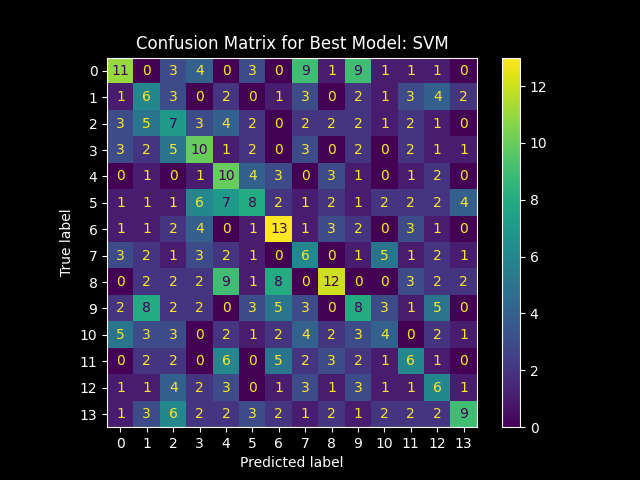

Test Accuracy of the best model (SVM): 24.37%


In [ ]:
# plot_confusion_matrix for last 5-sec
plot_confusion_matrix(best_model_last_movie_PCC, X_test_pcc_last_movie, y_test_pcc_last_movie, best_model_name_last_movie_PCC)

# print_test_accuracy  for last 5-sec
print_test_accuracy(best_model_last_movie_PCC, X_test_pcc_last_movie, y_test_pcc_last_movie, best_model_name_last_movie_PCC)

Conclusions:

The default network, including the posterior cingulate cortex (PCC), is typically active during rest, self-referential thinking, and mind-wandering. During film watching, the PCC might be less active compared to the VIS and ATN, as the viewer is engaged in an external task rather than internal thoughts.

This make it less reliable for primary classification tasks, and that's why the accuracy for PCC is the lowest, as we expected.

We would like to mention that the best accuracy for PCC was achieved by SVM.

#Modle VIS

In [ ]:
# Training models for VIS
best_model_first_movie_VIS, best_model_name_first_movie_VIS, accuracies_first_movie_VIS, best_params_first_movie_VIS =  k_fold_cross_validation(X_train_vis_first_movie,
                                                                                                                                y_train_vis_first_movie, k=3)
best_model_last_movie_VIS, best_model_name_last_movie_VIS, accuracies_last_movie_VIS, best_params_last_movie_VIS = k_fold_cross_validation(X_train_vis_last_movie, y_train_vis_last_movie,k=3)


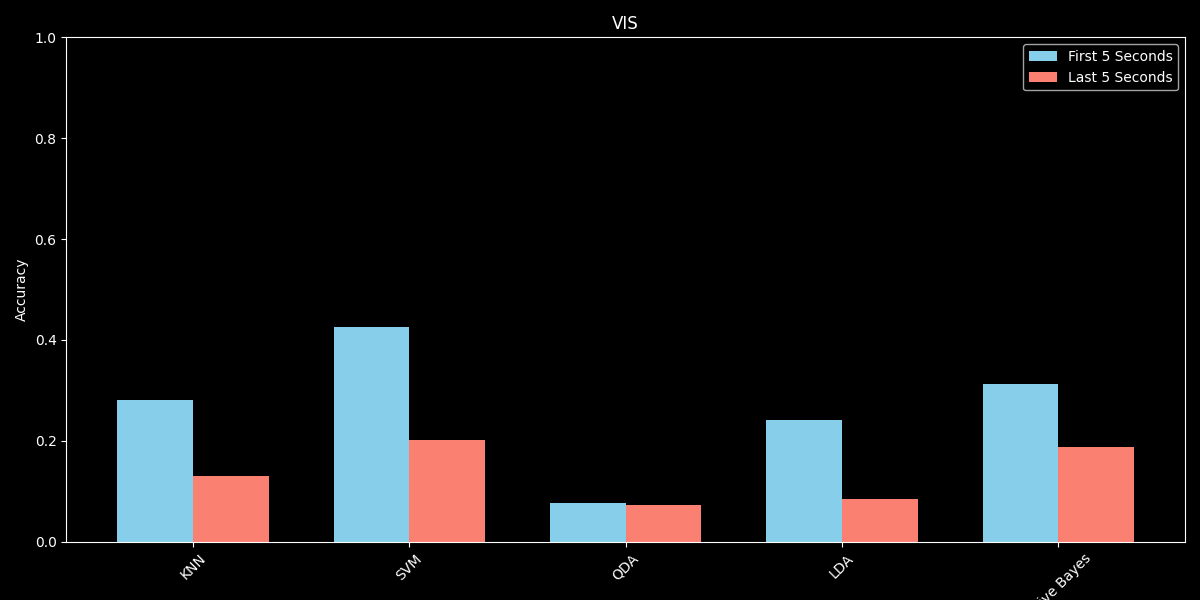

In [ ]:
# Plotting results for VIS
plot_accuracy_vs_model(accuracies_first_movie_VIS, accuracies_last_movie_PCC, 'VIS')

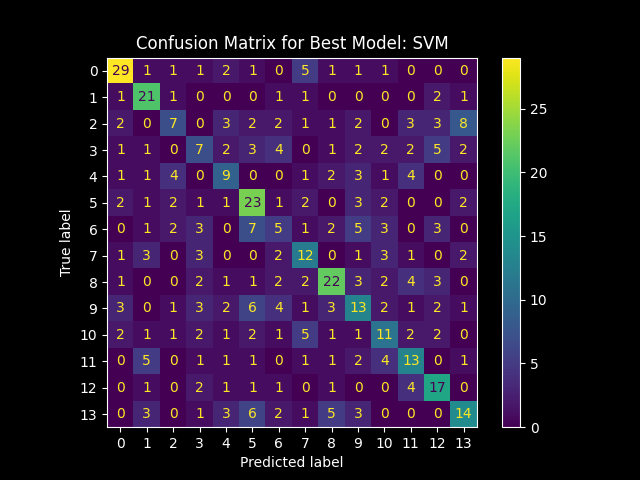

Test Accuracy of the best model (SVM): 42.65%


In [ ]:
# plot_confusion_matrix for first 5-sec
plot_confusion_matrix(best_model_first_movie_VIS, X_test_vis_first_movie, y_test_vis_first_movie, best_model_name_first_movie_VIS)

# print_test_accuracy  for first 5-sec
print_test_accuracy(best_model_first_movie_VIS, X_test_vis_first_movie, y_test_vis_first_movie, best_model_name_first_movie_VIS)

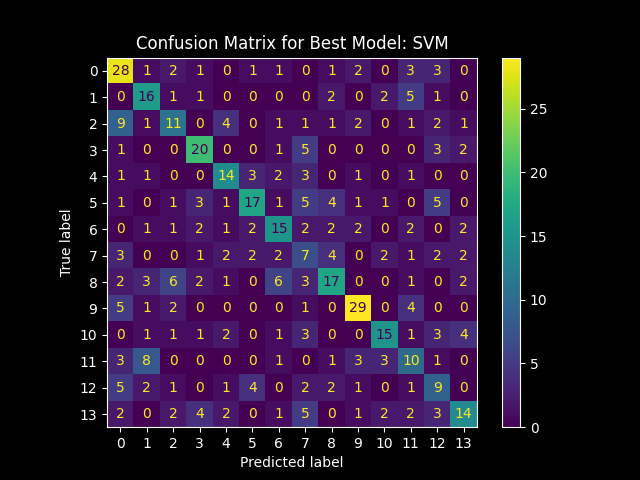

Test Accuracy of the best model (SVM): 46.64%


In [ ]:
# plot_confusion_matrix for last 5-sec
plot_confusion_matrix(best_model_last_movie_VIS, X_test_vis_last_movie, y_test_vis_last_movie, best_model_name_last_movie_VIS)

# print_test_accuracy  for last 5-sec
print_test_accuracy(best_model_last_movie_VIS, X_test_vis_last_movie, y_test_vis_last_movie, best_model_name_last_movie_VIS)

Conclusions:

The visual network is primarily responsible for processing visual information. During film watching, the VIS would be highly active as it processes the visual stimuli presented on the screen.

Since the VIS is consistently engaged in processing the visual stimuli of the film, it is likely to provide the most reliable data for classification tasks.

In our model, there was a slight difference between the VIS and ATN results (ATN is slightly more accurate), indicating that while both networks are highly effective in film classification, the ATN's involvement in cognitive engagement and attention allocation provides a marginal advantage over the VIS's visual processing capabilities.

We recieved best accuracy for VIS using the SVM linear classification, yet we expetced higher accuracy.


Regarding all 3 brain areas:

For the end of the movie, the results were a little more accurate than from the middle. This is likely due to increased viewer engagement and attention as the film reaches its climax and conclusion, which activates the ATN more intensely. The narrative structure at the end often includes key plot resolutions and emotional peaks, leading to more consistent neural patterns across viewers and improved classification accuracy

# Part 2- Classification of the 14 rest segments according to the last and first 5 seconds of each segment

# Data Load + Data Preprocessing

In [ ]:
atn_rest = loadmat('/content/drive/MyDrive/FMRI_FINAL/atn_roi_rest.mat')
pcc_rest = loadmat('/content/drive/MyDrive/FMRI_FINAL/pcc_roi_rest.mat')
vis_rest = loadmat('/content/drive/MyDrive/FMRI_FINAL/vis_roi_rest.mat')

In [ ]:
atn_rest = atn_rest['atn_roi_rest']
atn_rest.shape

(170, 14, 19, 361)

In [ ]:
pcc_rest = pcc_rest['pcc_roi_rest']
pcc_rest.shape

(170, 14, 19, 192)

In [ ]:
vis_rest = vis_rest['vis_roi_rest']
vis_rest.shape

(170, 14, 19, 101)

In [ ]:
first_5sec_atn_rest=transform_matrix(atn_rest, True)
last_5sec_atn_rest=transform_matrix(atn_rest, False)

first_5sec_pcc_rest=transform_matrix(pcc_rest, True)
last_5sec_pcc_rest=transform_matrix(pcc_rest, False)

first_5sec_vis_rest=transform_matrix(vis_rest, True)
last_5sec_vis_rest=transform_matrix(vis_rest, False)

In [ ]:
print(f"the shape of first_5sec_atn_rest: {first_5sec_atn_rest.shape}")
print(f"the shape of first_5sec_pcc_rest: {first_5sec_pcc_rest.shape}")
print(f"the shape of first_5sec_vis_rest: {first_5sec_vis_rest.shape}")

print(f"the shape of last_5sec_atn_rest: {last_5sec_atn_rest.shape}")
print(f"the shape of last_5sec_pcc_rest: {last_5sec_pcc_rest.shape}")
print(f"the shape of last_5sec_vis_rest: {last_5sec_vis_rest.shape}")

the shape of first_5sec_atn_rest: (2380, 5, 361)
the shape of first_5sec_pcc_rest: (2380, 5, 192)
the shape of first_5sec_vis_rest: (2380, 5, 101)
the shape of last_5sec_atn_rest: (2380, 5, 361)
the shape of last_5sec_pcc_rest: (2380, 5, 192)
the shape of last_5sec_vis_rest: (2380, 5, 101)


In [ ]:
first_5sec_atn_rest_flat = np.reshape(first_5sec_atn_rest, (2380, -1))
first_5sec_pcc_rest_flat = np.reshape(first_5sec_pcc_rest, (2380, -1))
first_5sec_vis_rest_flat = np.reshape(first_5sec_vis_rest, (2380, -1))

last_5sec_atn_rest_flat = np.reshape(last_5sec_atn_rest, (2380, -1))
last_5sec_pcc_rest_flat = np.reshape(last_5sec_pcc_rest, (2380, -1))
last_5sec_vis_rest_flat = np.reshape(last_5sec_vis_rest, (2380, -1))

In [ ]:
X_train_atn_first_rest, X_test_atn_first_rest, y_train_atn_first_rest, y_test_atn_first_rest = train_test_split(first_5sec_atn_rest_flat, labels_atn, test_size=0.2, random_state=42)
X_train_atn_last_rest, X_test_atn_last_rest, y_train_atn_last_rest, y_test_atn_last_rest = train_test_split(last_5sec_atn_rest_flat, labels_atn, test_size=0.2, random_state=42)

In [ ]:
X_train_pcc_first_rest, X_test_pcc_first_rest, y_train_pcc_first_rest, y_test_pcc_first_rest = train_test_split(first_5sec_pcc_rest_flat, labels_pcc, test_size=0.2, random_state=42)
X_train_pcc_last_rest, X_test_pcc_last_rest, y_train_pcc_last_rest, y_test_pcc_last_rest = train_test_split(last_5sec_pcc_rest_flat, labels_pcc, test_size=0.2, random_state=42)

In [ ]:
X_train_vis_first_rest, X_test_vis_first_rest, y_train_vis_first_rest, y_test_vis_first_rest= train_test_split(first_5sec_vis_rest_flat, labels_pcc, test_size=0.2, random_state=42)
X_train_vis_last_rest, X_test_vis_last_rest, y_train_vis_last_rest, y_test_vis_last_rest = train_test_split(last_5sec_vis_rest_flat, labels_vis, test_size=0.2, random_state=42)

# Model_atn

In [ ]:
# Training models for ATN
best_model_first_rest_ATN, best_model_name_first_rest_ATN, accuracies_first_rest_ATN, best_params_first_rest_ATN =  k_fold_cross_validation(X_train_atn_first_rest,
                                                                                                                                y_train_atn_first_rest, k=3)
best_model_last_rest_ATN, best_model_name_last_rest_ATN, accuracies_last_rest_ATN, best_params_last_rest_ATN = k_fold_cross_validation(X_train_atn_last_rest, y_train_atn_last_rest,k=3)


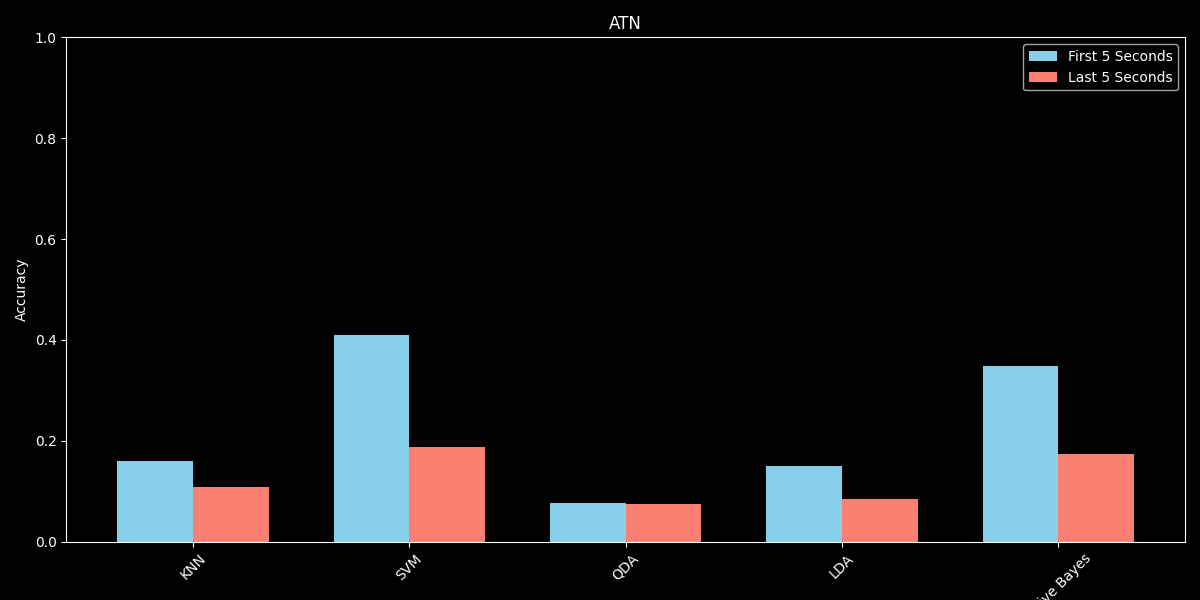

In [ ]:
# Plotting results for ATN
plot_accuracy_vs_model(accuracies_first_rest_ATN, accuracies_last_rest_ATN, 'ATN')

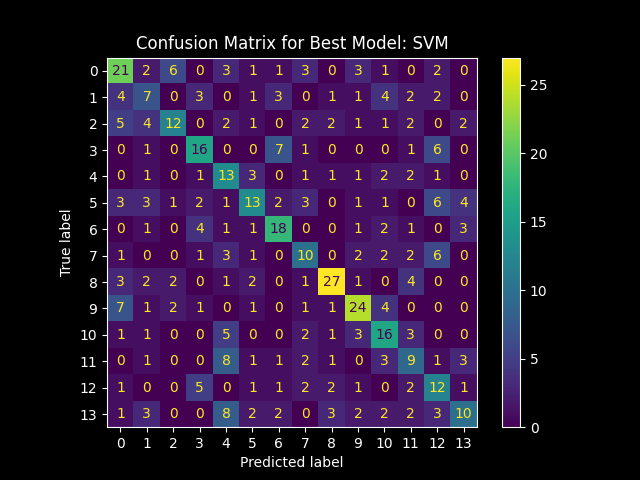

Test Accuracy of the best model (SVM): 43.70%


In [ ]:
# plot_confusion_matrix for first 5-sec
plot_confusion_matrix(best_model_first_rest_ATN, X_test_atn_first_rest, y_test_atn_first_rest, best_model_name_first_rest_ATN)

# print_test_accuracy for first 5-sec
print_test_accuracy(best_model_first_rest_ATN, X_test_atn_first_rest, y_test_atn_first_rest, best_model_name_first_rest_ATN)

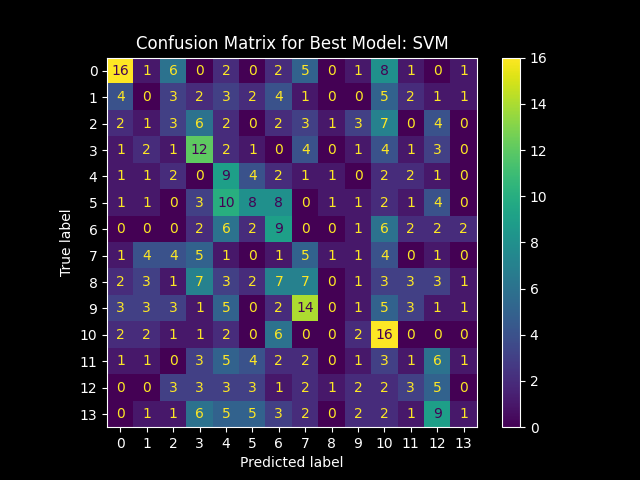

Test Accuracy of the best model (SVM): 18.07%


In [ ]:
# plot_confusion_matrix for first 5-sec
plot_confusion_matrix(best_model_last_rest_ATN, X_test_atn_last_rest, y_test_atn_last_rest, best_model_name_last_rest_ATN)

# print_test_accuracy for first 5-sec
print_test_accuracy(best_model_last_rest_ATN, X_test_atn_last_rest, y_test_atn_last_rest, best_model_name_last_rest_ATN)

Conclusions:

In the initial rest period (first 5-sec), the ATN showed the highest accuracy. We expected this results since it showed the highest accuracy during movie time.

During the initial rest period, subjects are likely transitioning from the movie-watching state to a resting state, which still requires some level of cognitive processing related to attention. The brain might be processing and integrating information from the movie, which engages the ATN.

We can see there was a drop in accuracy during the last 5 seconds- generaly, the drop for all regions during the last 5 seconds of rest suggests that brain activity becomes more homogenous and less distinguishable in relation to the movie stimuli as the resting period progresses. We also expected this result.

# Model_pcc

In [ ]:
# Training models for PCC
best_model_first_rest_PCC, best_model_name_first_rest_PCC, accuracies_first_rest_PCC, best_params_first_rest_PCC =  k_fold_cross_validation(X_train_pcc_first_rest,
                                                                                                                                y_train_pcc_first_rest, k=3)
best_model_last_rest_PCC, best_model_name_last_rest_PCC, accuracies_last_rest_PCC, best_params_last_rest_PCC = k_fold_cross_validation(X_train_pcc_last_rest, y_train_pcc_last_rest,k=3)


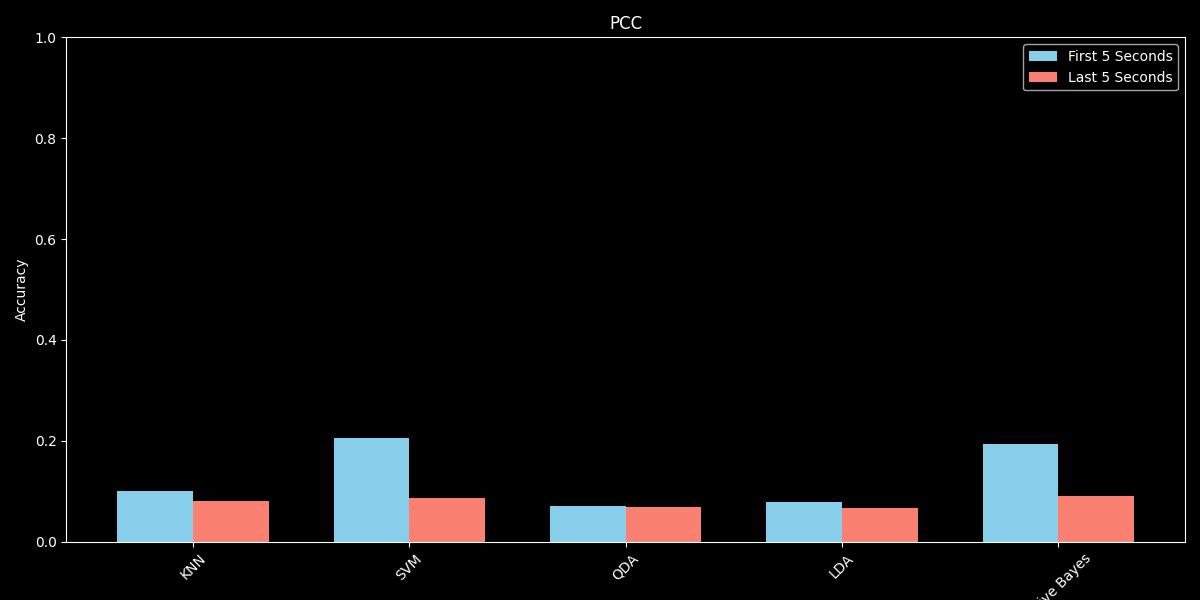

In [ ]:
# Plotting results for PCC
plot_accuracy_vs_model(accuracies_first_rest_PCC, accuracies_last_rest_PCC, 'PCC')

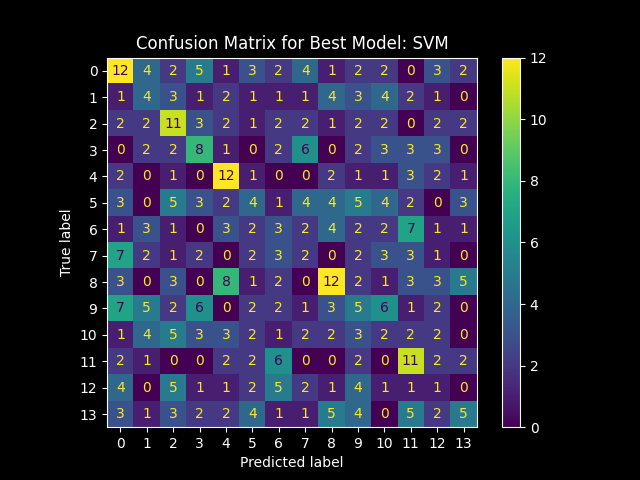

Test Accuracy of the best model (SVM): 19.33%


In [ ]:
# plot_confusion_matrix for first 5-sec
plot_confusion_matrix(best_model_first_rest_PCC, X_test_pcc_first_rest, y_test_pcc_first_rest, best_model_name_first_rest_PCC)

# print_test_accuracy  for first 5-sec
print_test_accuracy(best_model_first_rest_PCC, X_test_pcc_first_rest, y_test_pcc_first_rest, best_model_name_first_rest_PCC)

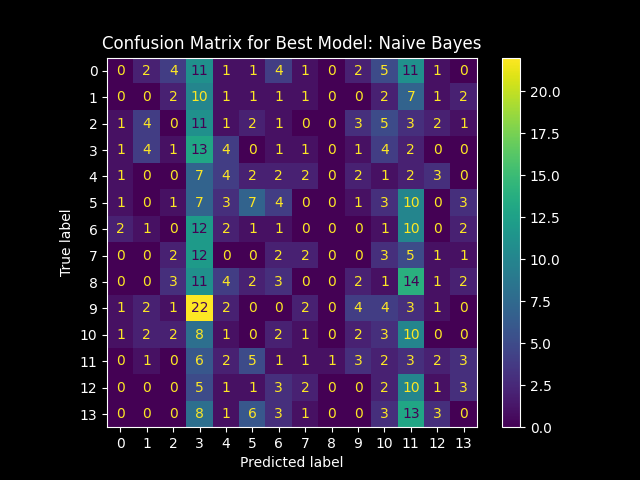

Test Accuracy of the best model (Naive Bayes): 7.98%


In [ ]:
# plot_confusion_matrix for last 5-sec
plot_confusion_matrix(best_model_last_rest_PCC, X_test_pcc_last_rest, y_test_pcc_last_rest, best_model_name_last_rest_PCC)

# print_test_accuracy  for last 5-sec
print_test_accuracy(best_model_last_rest_PCC, X_test_pcc_last_rest, y_test_pcc_last_rest, best_model_name_last_rest_PCC)

Conclusion:

During the last 5 seconds of rest, the PCC had the lowest accuracy in this classification task. While the PCC is more active during rest periods, its activity in the later stages of rest becomes more homogeneous and less influenced by external stimuli, such as a movie. This leads to more uniform brain activity focused on internal processes, making it less effective for distinguishing between different movies.

# Model_VIS

In [ ]:
# Training models for VIS
best_model_first_rest_VIS, best_model_name_first_rest_VIS, accuracies_first_rest_VIS, best_params_first_rest_VIS =  k_fold_cross_validation(X_train_vis_first_rest,
                                                                                                                                y_train_vis_first_rest, k=3)
best_model_last_rest_VIS, best_model_name_last_rest_VIS, accuracies_last_rest_VIS, best_params_last_rest_VIS = k_fold_cross_validation(X_train_vis_last_rest, y_train_vis_last_rest,k=3)


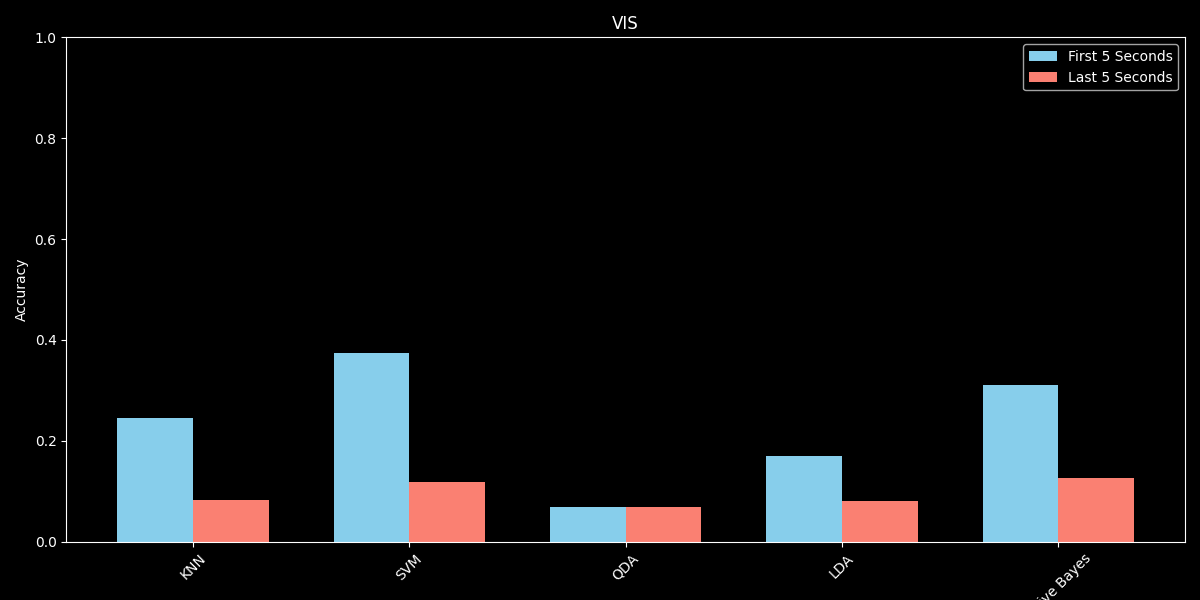

In [ ]:
# Plotting results for VIS
plot_accuracy_vs_model(accuracies_first_rest_VIS, accuracies_last_rest_VIS, 'VIS')

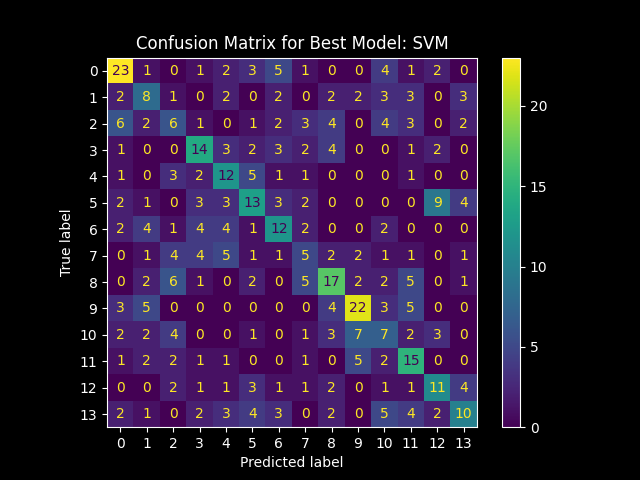

Test Accuracy of the best model (SVM): 36.76%


In [ ]:
# plot_confusion_matrix for first 5-sec
plot_confusion_matrix(best_model_first_rest_VIS, X_test_vis_first_rest, y_test_vis_first_rest, best_model_name_first_rest_VIS)

# print_test_accuracy  for first 5-sec
print_test_accuracy(best_model_first_rest_VIS, X_test_vis_first_rest, y_test_vis_first_rest, best_model_name_first_rest_VIS)

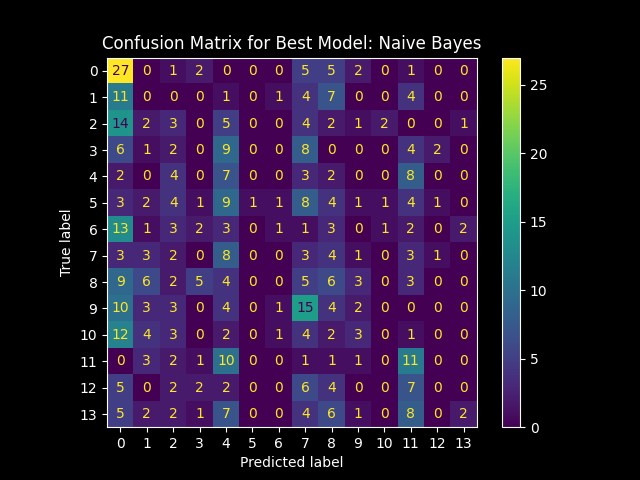

Test Accuracy of the best model (Naive Bayes): 13.24%


In [ ]:
# plot_confusion_matrix for last 5-sec
plot_confusion_matrix(best_model_last_rest_VIS, X_test_vis_last_rest, y_test_vis_last_rest, best_model_name_last_rest_VIS)

# print_test_accuracy  for last 5-sec
print_test_accuracy(best_model_last_rest_VIS, X_test_vis_last_rest, y_test_vis_last_rest, best_model_name_last_rest_VIS)

Conclusion:

The VIS also showed relatively high accuracy(comparing to our results), which makes sense since visual processing areas might still be active due to the recent visual stimuli from the movie.

In the last 5-sec the VIS’s accuracy also drops, likely due to the reduction in visual stimulus processing as subjects settle into rest.

#XGBOOST and Random Forest Tree and Deep clasification

In part 1 of the task we recieved accuracy of 42.65% for the VIS brain area (during first 5-sec of the movie).

Now, we'll try to improve the accuracy of classification with XGBOOST and Random Forest Tree.These methods handle non-linear relationships and reduce overfitting through ensemble techniques.

XGBoost uses gradient boosting to combine weak learners and includes regularization to improve generalization.

Random Forest builds multiple decision trees and averages their results to capture complex patterns and reduce variance.

Both methods also provide feature importance scores, helping identify the most significant brain activity patterns for classification, and handle imbalanced datasets effectively.

Test Accuracy of the best model (XGBoost): 36.34%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.58      0.60        43
           1       0.61      0.68      0.64        28
           2       0.29      0.21      0.24        34
           3       0.17      0.19      0.18        32
           4       0.34      0.42      0.38        26
           5       0.37      0.40      0.39        40
           6       0.12      0.06      0.08        32
           7       0.29      0.43      0.35        28
           8       0.57      0.47      0.51        43
           9       0.12      0.12      0.12        42
          10       0.29      0.31      0.30        32
          11       0.35      0.57      0.44        30
          12       0.54      0.46      0.50        28
          13       0.31      0.26      0.29        38

    accuracy                           0.36       476
   macro avg       0.36      0.37      0.36       476

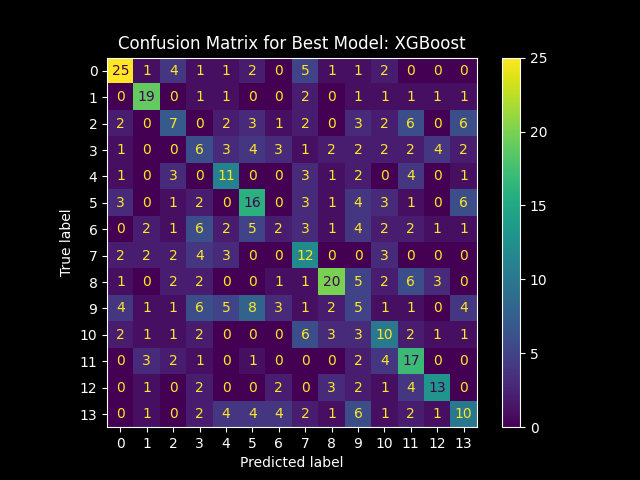

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for Best Model: {model_name}')
    plt.show()

def print_test_accuracy(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy of the best model ({model_name}): {test_accuracy * 100:.2f}%")

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=14, max_depth=5, learning_rate=0.01, n_estimators=200, random_state=42)
xgb_model.fit(X_train_vis_first_movie, y_train_vis_first_movie)

y_pred_xgb = xgb_model.predict(X_test_vis_first_movie)

# Evaluation for XGBoost
print_test_accuracy(xgb_model, X_test_vis_first_movie, y_test_vis_first_movie, 'XGBoost')
print("XGBoost Classification Report:")
print(classification_report(y_test_vis_first_movie, y_pred_xgb))
plot_confusion_matrix(xgb_model, X_test_vis_first_movie, y_test_vis_first_movie, 'XGBoost')


Conclusions:

We received accuracy of 36.34% using XGBOOST model, which is lower than SVM linear classification.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Test Accuracy of the best model (Random Forest): 40.13%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.70      0.65        43
           1       0.45      0.79      0.57        28
           2       0.33      0.18      0.23        34
           3       0.19      0.16      0.17        32
           4       0.37      0.38      0.38        26
           5       0.40      0.50      0.44        40
           6       0.25      0.22      0.23        32
           7       0.32      0.46      0.38        28
           8       0.57      0.47      0.51        43
           9       0.30      0.24      0.27        42
          10       0.40      0.12      0.19        32
          11       0.33      0.53      0.41        30
          12       0.48      0.57      

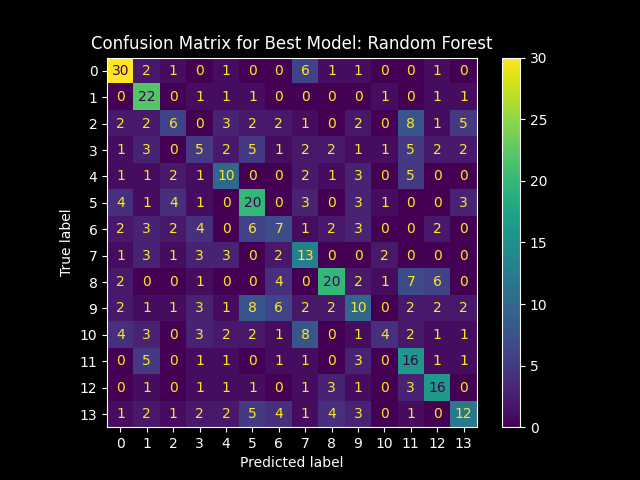

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid_search.fit(X_train_vis_first_movie, y_train_vis_first_movie)

print("Best parameters found for Random Forest:", rf_grid_search.best_params_)

y_pred_rf = rf_grid_search.predict(X_test_vis_first_movie)

# Evaluation for Random Forest
print_test_accuracy(rf_grid_search.best_estimator_, X_test_vis_first_movie, y_test_vis_first_movie, 'Random Forest')
print("Random Forest Classification Report:")
print(classification_report(y_test_vis_first_movie, y_pred_rf))
plot_confusion_matrix(rf_grid_search.best_estimator_, X_test_vis_first_movie, y_test_vis_first_movie, 'Random Forest')

Conclusions:

We received accuracy of 40.13% using Random Forest model, which is better than XGBOOST, but yet, lower than SVM linear classification.


**Deep Modle**

In [ ]:
!pip install tensorflow


ERROR: Operation cancelled by user


Epoch 1/50
53/53 [==============================] - 3s 15ms/step - loss: 9.2906 - accuracy: 0.1369 - val_loss: 8.2841 - val_accuracy: 0.1905
Epoch 2/50
53/53 [==============================] - 1s 10ms/step - loss: 7.6717 - accuracy: 0.2245 - val_loss: 6.8866 - val_accuracy: 0.2801
Epoch 3/50
53/53 [==============================] - 0s 8ms/step - loss: 6.4030 - accuracy: 0.2893 - val_loss: 5.7960 - val_accuracy: 0.3445
Epoch 4/50
53/53 [==============================] - 0s 8ms/step - loss: 5.4129 - accuracy: 0.3109 - val_loss: 4.9249 - val_accuracy: 0.3501
Epoch 5/50
53/53 [==============================] - 0s 8ms/step - loss: 4.6476 - accuracy: 0.3379 - val_loss: 4.3007 - val_accuracy: 0.3725
Epoch 6/50
53/53 [==============================] - 0s 8ms/step - loss: 4.0687 - accuracy: 0.3685 - val_loss: 3.8273 - val_accuracy: 0.3810
Epoch 7/50
53/53 [==============================] - 1s 13ms/step - loss: 3.6391 - accuracy: 0.3836 - val_loss: 3.4627 - val_accuracy: 0.3922
Epoch 8/50
53/53 

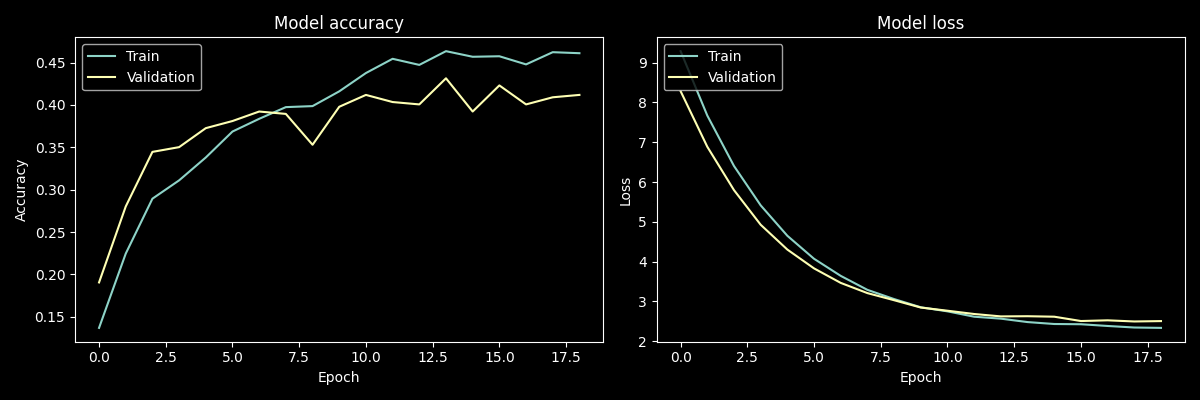

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Initial split to separate out the training data (70%) and the temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(first_5sec_vis_movie_flat, labels_pcc, test_size=0.3, random_state=42)

# Split the temporary set into validation (50% of temp, which is 15% of total) and test (50% of temp, which is 15% of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=14)
y_val_one_hot = to_categorical(y_val, num_classes=14)
y_test_one_hot = to_categorical(y_test, num_classes=14)

# Define the model with L2 regularization
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.02)))  # 14 categories

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val_one_hot),
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Conclusions:

We received accuracy of 41.18% using deep model model, which is lower than SVM linear classification. We can observe little overfitting, which may affect the validation results.

# Conclusions




 The ATN provided the most distinguishable patterns for classifying which movie a subject watched, reflecting its role in focusing attention and managing cognitive resources.

 The PCC, part of the default mode network, consistently showed the lowest accuracy, especially during rest periods.

 The VIS was in between, capturing visual processing patterns but not as effectively as the ATN.

In the first 5 seconds of the movie, the ATN yielded the best results, though the overall accuracy was still low, which was lower than we expected. The PCC had the lowest accuracy in this period.
 When comparing the first 5 seconds of rest to the last 5 seconds of the movie, we observed a decrease in classification accuracy, with the last 5 seconds showing lower accuracy than the first.

 Additionally, during rest periods, all accuracies were lower, with the PCC showing the least accuracy due to its homogeneous and internally focused.

The non-linear classification did not yielded better accuracies.